In [1]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt


In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

TRAIN_PATH = r'D:\dataset seg1\train_images/'
TEST_PATH = r'D:\dataset seg1\test_images/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train=[]
Y_train=[]


In [3]:
len(train_ids)

155

In [4]:
print('Resizing training images and masks')

for id_ in tqdm(train_ids , total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + r'\images\\' + id_ + '.png')[:,:]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train.append(list(img))  #Fill empty X_train with values from img
                 
    mask = imread(path + r'\masks\\' + id_ + '.png')
    mask= resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train.append(list(mask))

  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [11:09<00:00,  4.32s/it]


In [5]:
X_train=np.array(X_train)
Y_train=np.array(Y_train,np.bool)

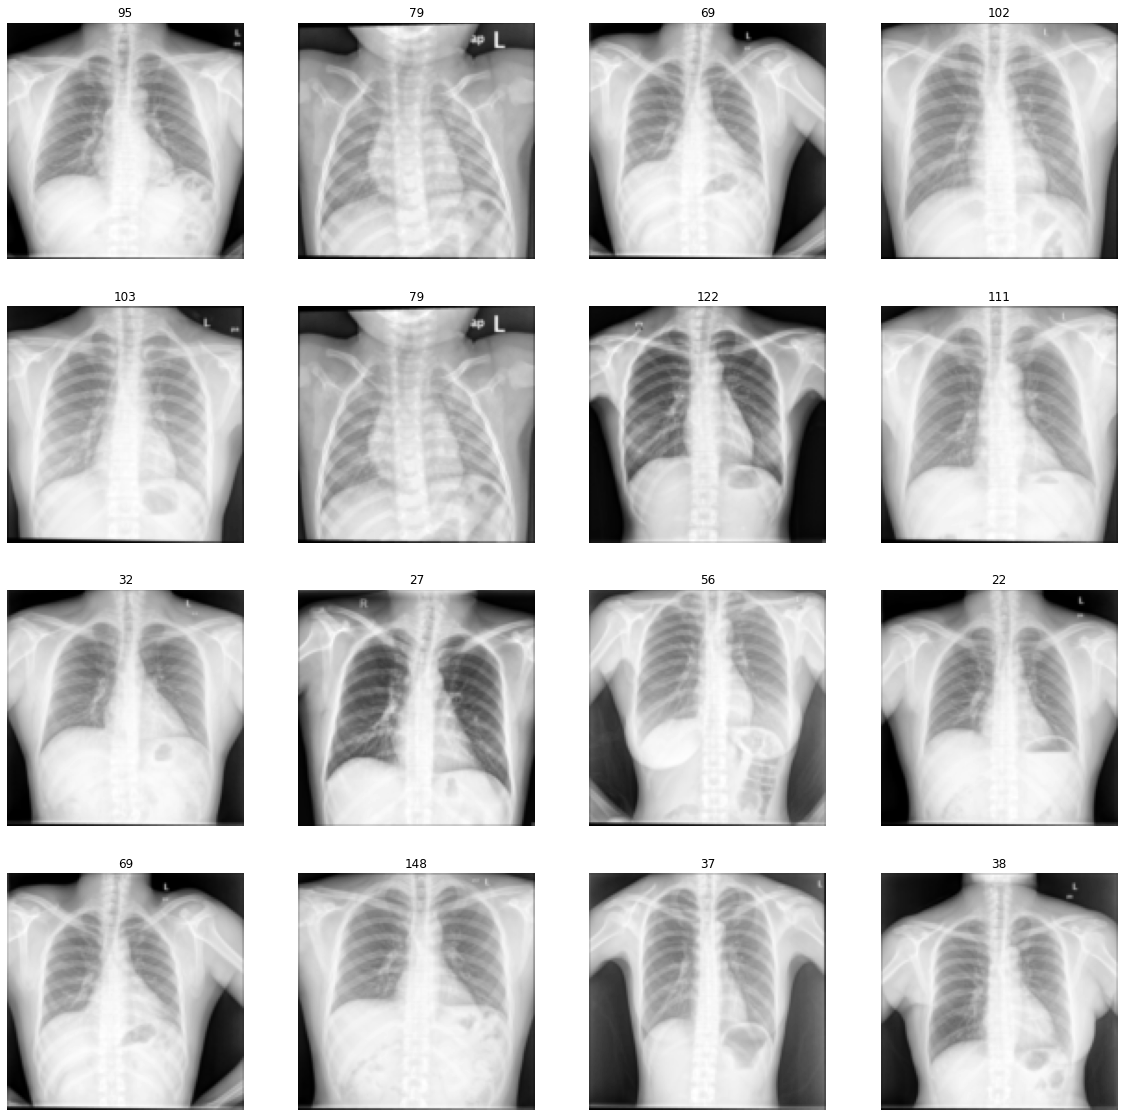

In [6]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

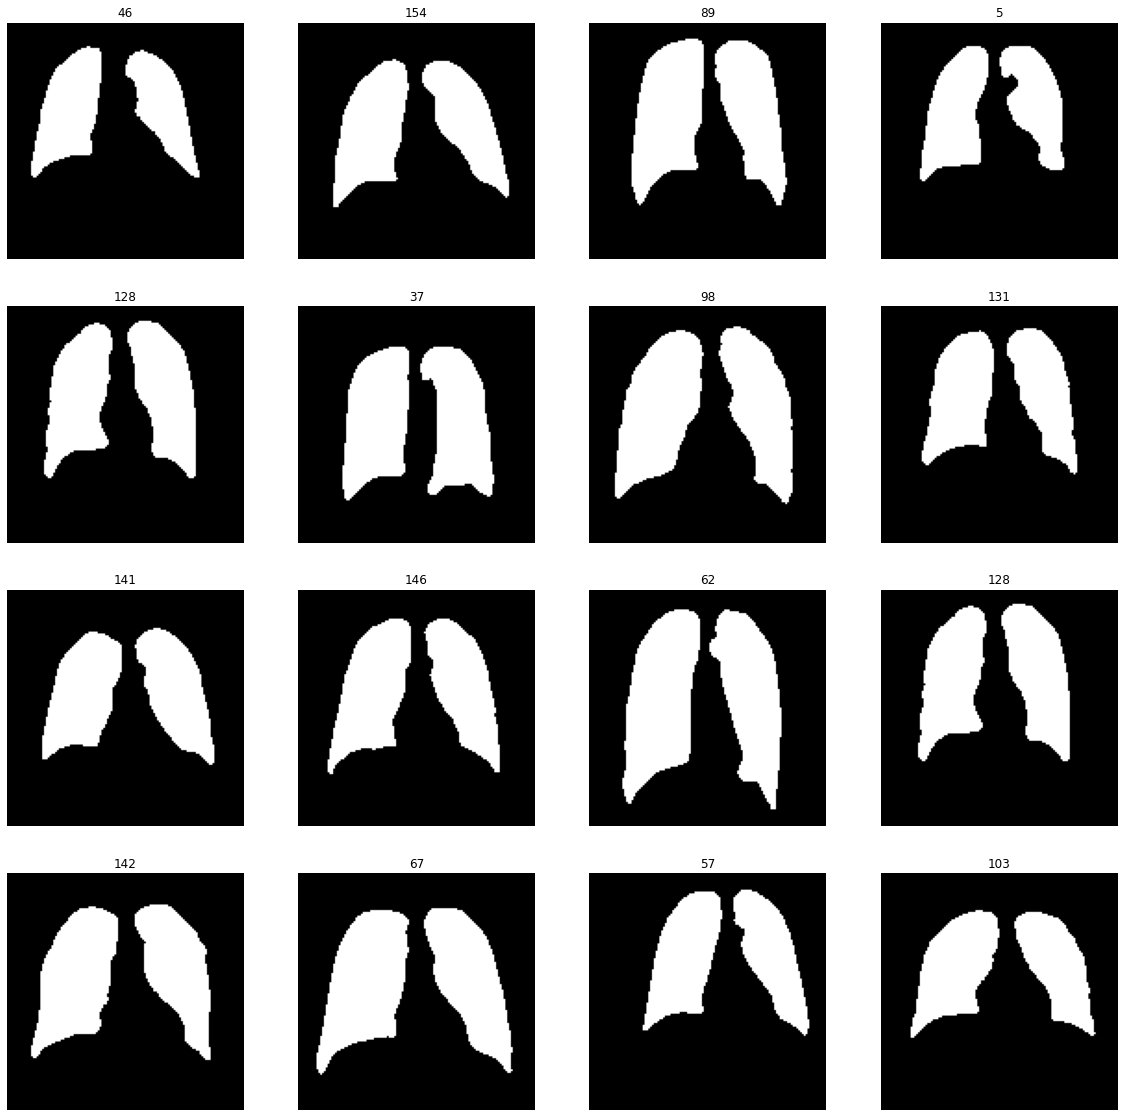

In [7]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(Y_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [8]:
len(test_ids)

65

In [9]:
X_test = []
sizes_test = []

print('Resizing test images') 

for id_ in tqdm(test_ids, total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '\\'+ id_ + '.png')[:,:]
    
    sizes_test.append([img.shape[0], img.shape[1]])
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    X_test.append(list(img))

  0%|                                                                                           | 0/65 [00:00<?, ?it/s]

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [09:41<00:00,  8.94s/it]


In [10]:
X_test=np.array(X_test)

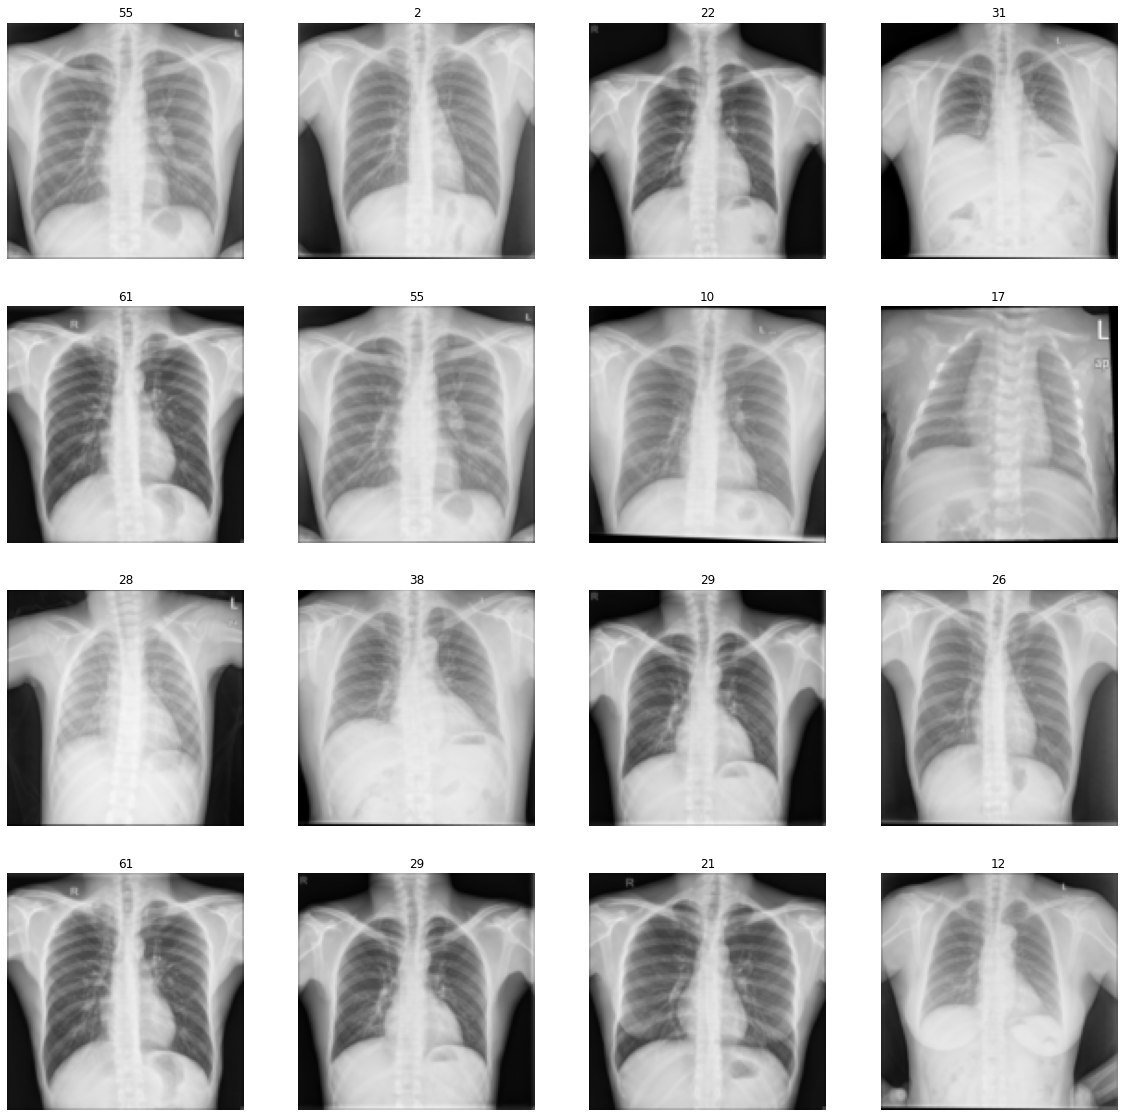

In [11]:
X_test=X_test/255
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_test),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_test[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [12]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [13]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=5)


Epoch 1/5
9/9 [==============================] - 22s 2s/step - loss: 0.6623 - accuracy: 0.6840 - val_loss: 0.5767 - val_accuracy: 0.7657
Epoch 2/5
9/9 [==============================] - 18s 2s/step - loss: 0.5843 - accuracy: 0.7344 - val_loss: 0.5505 - val_accuracy: 0.7657
Epoch 3/5
9/9 [==============================] - 18s 2s/step - loss: 0.5401 - accuracy: 0.7352 - val_loss: 0.5505 - val_accuracy: 0.7657
Epoch 4/5
9/9 [==============================] - 18s 2s/step - loss: 0.4680 - accuracy: 0.7366 - val_loss: 0.3836 - val_accuracy: 0.7657
Epoch 5/5
9/9 [==============================] - 18s 2s/step - loss: 0.3947 - accuracy: 0.7560 - val_loss: 0.3854 - val_accuracy: 0.7661


In [14]:
y_pred=model.predict(X_train)

In [15]:
y_pred_p=(y_pred > 0.5).astype(np.uint8)

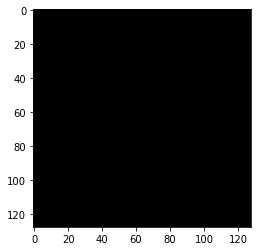

In [16]:
plt.imshow(y_pred_p[0],cmap='gray')